**Rationale** Texts have become one of the most ubiquitous forms of marketing data in the digital economy. Perhaps nowhere is this more prevalent than in the online reviews domain. In our notes, we examined how natural language processing (NLP) techniques can be applied to Yelp restaurant reviews. On this homework assignment, you will apply the same tools to mine TripAdvisor hotel reviews. This dataset includes all TripAdvisor reviews written in 2015 (through part of 2016) for high review volume Vegas resorts and was collected as part of a large web crawl of over 50 Million online reviews at over 428k worldwide hotels by your professor and his colleague, Dr. Alex Chaudhry in 2016. 

* [Dataset](https://drive.google.com/drive/folders/16eyzTI32aKsKiLf9oPMzL3v2U30afd01?usp=sharing)

You will only need:
* vegas_2015_reviews.csv contains the reviews 
* vegas_info.csv contains a list of venues in Vegas

Get started early on this assignment, some components **take a while to run**. 

This assignment will be slightly different. Please follow all prompts.

1. This is a walkthrough tutorial, mostly. I have provided you with most of the necessary code. Your job is to run it, read it, understand how it relates to NLP concepts.
1. There are many questions throughout. You will primarily be graded on these.
1. There are a few places where I ask you to write some code. Pay attention to every cell, make sure you don't skip a cell that you must fill in on accident. Hopefully, this foces you to read through the code thoroughly.

# Imports and helper functions (execute these cells first)

In [1]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from textblob import TextBlob 


In [3]:
# imports

import nltk
nltk.download('stopwords') # download stopwords from NLTK servers
from nltk.corpus import stopwords # import them
sw = stopwords.words('english')


import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, time # standard imports
from itertools import chain

# for sentiment analysis
from textblob import TextBlob 

# for doing text processing and LDA
import spacy
from gensim.models.ldamulticore import LdaMulticore # this is the multi-core version
from gensim import corpora # import the corpora module
from gensim.models import Phrases
from gensim.models import tfidfmodel
from gensim.models.word2vec import LineSentence
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Helper Functions
def line_doc(filename, encode = 'utf-8'):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    with open(filename, 'r', encoding = encode) as f:
        for txt in f:
            # yield returns next line
            yield txt.replace('\\n', '\n')
            # and get rid of any line breaks

# parsing to be done per sentence
def lemmatize(s, exclude):
    return [w.lemma_.lower() for w in s if (w.lemma_ not in exclude)&(~w.is_punct)]


# next will be a function that will pass a filename to the line_doc function
# and generate the parsed versions of ***EVERY SENTENCE***
# this function streams a file at filename and yields one parsed sentence at a time
def lemmatize_sentence_corpus(filename,nlp, batch_size, n_threads, sw=[], exclusions=[], encode = 'utf-8'):
    nlp.disable_pipes(["ner"]) # disable ner and tagger makes it a little faster
    # batch_size is the number of documents to parse in memory at a time
    # n_threads it the number of parallel (simultaneous processes to run)
    # n_threads is limited by the number of virtual cpu's on the system
    # the default free Colab system has only 2 virtual cores
    # most modern computers have at least 4
    exclude = set(sw + exclusions)
    for parsed_txt in nlp.pipe(line_doc(filename, encode = encode),batch_size=batch_size, n_threads=n_threads):
            for sent in parsed_txt.sents:
                yield ' '.join(lemmatize(sent, exclude))


def write_parsed_sentence_corpus(readfile, writefile, nlp, batch_size, n_threads, sw=[], exclusions =[], encode = 'utf-8'):
    streamingfile = lemmatize_sentence_corpus(readfile,nlp, batch_size, n_threads, sw=sw, exclusions=exclusions, encode = encode)
    with open(writefile, 'w', encoding = encode) as f:
        for sentence in streamingfile:
            if len(sentence)>0: # write sentence if includes non stopwords
                f.write(sentence+'\n')
    print('Success')


def phrase_detection(parsedfile, folderpath, passes = 2, returnmodels = True,threshold=10., encode = 'utf-8'):
    """
    parsedfile is the file location and name of the parsed sentence file
    folderpath is where the models and phrase detected texts need to be stored

    This function does phrase modeling. User specifies the number of passes.
    Each additional pass detects longer phrases. The maximum detectable phrase length for
    each pass, n, is 2^n.
    Returns the list of models by default. Also saves models and intermediary
    phrased sentences for each pass.
    """
    ngram = list()
    for it in range(passes):
        gen = LineSentence(parsedfile)
        gram=Phrases(gen, threshold = threshold)
        ngram.append(gram)
        modelpath = folderpath+'phrase_model_{}.phrasemodel'.format(it+1)
        textpath = folderpath+'sent_gram_{}.txt'.format(it+1)
        parsedfile = textpath
        gram.save(modelpath)
        # Write sentence n-gram
        with open(textpath, 'w', encoding=encode) as f:
            for sent in gen:
                new_sent = ' '.join(gram[sent])
                f.write(new_sent + '\n')

    if returnmodels == True:
        return ngram


def phrase_prediction(rawfilepath, outpath,nlp, grams, sw =[], exclusions = [], batch_size = 500, n_threads = 2, encode = 'utf-8'):
    """
    rawfilepath is where the raw reviews (where 1 line = 1 review) are saved 
    outpath is where to save the resulting parsed and phrase modeled reviews
    nlp is the spacy parser object
    grams is a list of phrasemodels
    sw is a list of stopwords
    exclusions are additional words to exclude

    """
    with open(outpath, 'w', encoding = encode) as f:
        
        nlp.disable_pipes(["ner"]) # disable ner and tagger makes it a little faster
        exclude = set(sw + exclusions)
        
        for parsed_txt in nlp.pipe(line_doc(rawfilepath, encode = encode),batch_size=batch_size, n_threads=n_threads):
            doc = list()
            for sent in parsed_txt.sents:
                parsed = lemmatize(sent, exclude)
                for gram in grams: # loop through phrase models
                    parsed = gram[parsed] # apply phrase model transformation to sentence
                doc.append(' '.join(parsed).strip()) # append resulting phrase modeled sentence to list "doc"
            # write the transformed review as a single line in the new file
            txt_gram = ' '.join(doc).strip() # join all sentences in doc together as txt_gram
            f.write(txt_gram + '\n') # write the entire phrase modeled and parsed doc as one line in file

# Put together the dataset (1 point)

In [5]:
fpath = 'drive/MyDrive/Datasets/' # change this filepath
os.listdir(fpath)

['renttherunway_final_data.json',
 'telecom_churn.csv',
 'facebook_ads.csv',
 'starbucks_promos.csv',
 'avocado.csv',
 'temple_traffic.csv',
 'vegas_vinfo.csv',
 'vegas2015reviews.csv',
 'nlppath']

In [6]:
# read in the vegas_vinfo file (vegas venue info)
df_biz = pd.read_csv(fpath + 'vegas_vinfo.csv', index_col = 0)
df_biz.head()

,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat,gd
0,"[10, 33]",60.0,NaN,"[-115.06332, 36.1191]",{},Hotel_Review,{'Services': 'Free Parking Banquet Room Self-S...,"{'Number of rooms:': '398 ', 'Address:': '3890...",Las Vegas RV Resort,4.0,g45963-d3600552
1,"[209, 267]",63.0,NaN,"[-115.08308, 36.127922]",{},Hotel_Review,{'Things to do': 'Pool Fitness Center with Gym...,"{'Address:': '4240 Boulder Hwy, Las Vegas, NV ...",Crossland Economy Studios - Las Vegas - Boulde...,2.5,g45963-d97850
2,"[197, 267]",100.0,NaN,"[-115.19604, 36.20166]",{},Hotel_Review,"{'Room types': 'Non-Smoking Rooms ', 'Services...","{'Address:': '2400 N Rancho Dr, Las Vegas, NV ...",Fiesta Rancho Hotel and Casino,2.5,g45963-d121329
3,"[228, 267]",27.0,NaN,"[-115.19868, 36.201473]",{},Hotel_Review,"{'Things to do': 'Pool ', 'About the property'...",{'Also Known As:': 'Budget Suites Of America N...,Budget Suites of America North Rancho Drive,1.5,g45963-d91750
4,"[1, 33]",271.0,NaN,"[-115.1785, 36.040703]",{},Hotel_Review,{'Services': 'Self-Serve Laundry Free Parking ...,{'Also Known As:': 'Oasis Las Vegas Rv Hotel L...,Oasis Las Vegas RV Resort,4.5,g45963-d226809


Variable definitions
1. ranking: list [hotel rank, total hotels in neighborhood]
1. rating_vol: total ratings
1. rdetails: ignore, none of hotels have this field (only restaurants do)
1. lnglat: [longitude,latitude] of hotel
1. rsubrating: ignore, only restaurants have this
1. amenities: a dictionary of amenities categories mapped to amenities list
1. details: a dictionary of hotel information fields mapped to hotel data (like addrese, phone, website, etc.)
1. v_name: the official name of the hotel 
1. rating_cat: The summary star rating (in half star increments) displayed to the user. 
1. gd: The unique hotel identifier.

In [ ]:
# return the shape of df_biz:
df_biz.shape

(237, 11)

In [ ]:
# preview df_biz
df_biz.head()

,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat,gd
0,"[10, 33]",60.0,NaN,"[-115.06332, 36.1191]",{},Hotel_Review,{'Services': 'Free Parking Banquet Room Self-S...,"{'Number of rooms:': '398 ', 'Address:': '3890...",Las Vegas RV Resort,4.0,g45963-d3600552
1,"[209, 267]",63.0,NaN,"[-115.08308, 36.127922]",{},Hotel_Review,{'Things to do': 'Pool Fitness Center with Gym...,"{'Address:': '4240 Boulder Hwy, Las Vegas, NV ...",Crossland Economy Studios - Las Vegas - Boulde...,2.5,g45963-d97850
2,"[197, 267]",100.0,NaN,"[-115.19604, 36.20166]",{},Hotel_Review,"{'Room types': 'Non-Smoking Rooms ', 'Services...","{'Address:': '2400 N Rancho Dr, Las Vegas, NV ...",Fiesta Rancho Hotel and Casino,2.5,g45963-d121329
3,"[228, 267]",27.0,NaN,"[-115.19868, 36.201473]",{},Hotel_Review,"{'Things to do': 'Pool ', 'About the property'...",{'Also Known As:': 'Budget Suites Of America N...,Budget Suites of America North Rancho Drive,1.5,g45963-d91750
4,"[1, 33]",271.0,NaN,"[-115.1785, 36.040703]",{},Hotel_Review,{'Services': 'Self-Serve Laundry Free Parking ...,{'Also Known As:': 'Oasis Las Vegas Rv Hotel L...,Oasis Las Vegas RV Resort,4.5,g45963-d226809


In [ ]:
df_biz.gd.unique()

array(['g45963-d3600552', 'g45963-d97850', 'g45963-d121329',
       'g45963-d91750', 'g45963-d226809', 'g45963-d287616',
       'g45963-d258899', 'g45963-d1123368', 'g45963-d91904',
       'g45963-d91878', 'g45963-d121309', 'g45963-d224853',
       'g45963-d91814', 'g45963-d7381166', 'g45963-d91853',
       'g45963-d121318', 'g45963-d91909', 'g45963-d76091',
       'g45963-d310164', 'g45963-d91907', 'g45963-d1761659',
       'g45963-d97971', 'g45963-d121313', 'g45963-d91745',
       'g45963-d97693', 'g45963-d1228551', 'g45963-d121312',
       'g45963-d91859', 'g45963-d97704', 'g45963-d121302',
       'g45963-d91673', 'g45963-d503598', 'g45963-d530410',
       'g45963-d653214', 'g45963-d294793', 'g45963-d1526513',
       'g45963-d234836', 'g45963-d91794', 'g45963-d294800',
       'g45963-d91891', 'g45963-d91871', 'g45963-d257173',
       'g45963-d503601', 'g45963-d91930', 'g45963-d619205',
       'g45963-d97730', 'g45963-d217597', 'g45963-d503600',
       'g45963-d97691', 'g45963-d91764

**Answer these**
1. What does 1 row of `df_biz` represent (e.g., reviewers, hotels, cities, etc.)? **One review of a specific hotel** \
1. How many hotels are in this dataset? **After counting, 237**


In [7]:
# read in the vegas2015reviews.csv file
df = pd.read_csv(fpath + 'vegas2015reviews.csv', index_col = 0)
df.head()

,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username
15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby
15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H
15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser
15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates
15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A


Variable definitions

1. gd: hotel identifier
1. helpful_num: number of helpful votes
1. location: location of the reviewer
1. mgrRspnDummy: whether a manager responded to the review
1. mgr_res_date: when the manager responded
1. mrtext: reply of the manager
1. ratingDate: when the review was written
1. review_id: unique identifer for each review
1. reviewrating: rationg (1-5) given by the reviewer
1. reviewtext: the text of the review
1. reviewtitle: title of the review
1. stay_month: 1-12 month of the stay
1. stay_year: year of the stay
1. travel_category: stated purpose of the stay
1. username: user's tripadvisor screen name

In [8]:
# convert ratingDate column to pandas datetime format using the pd.to_datetime function
df.ratingDate = pd.to_datetime(df.ratingDate)

In [9]:
df.ratingDate.dtype

dtype('<M8[ns]')

In [10]:
# get the shape of the dataframe df
df.shape

(46644, 15)

In [ ]:
# preview df
df.head()

,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username
15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby
15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H
15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser
15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates
15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A


In [ ]:
# look at the columns of df (e.g. df.columns)
df.columns

Index(['gd', 'helpful_num', 'location', 'mgrRspnDummy', 'mgr_res_date',
       'mrtext', 'ratingDate', 'review_id', 'reviewrating', 'reviewtext',
       'reviewtitle', 'stay_month', 'stay_year', 'travel_category',
       'username'],
      dtype='object')

In [ ]:
# what are the columns that belong to both df and df_biz?
set(df.columns).intersection(set(df_biz.columns))

{'gd'}

**Answer this**

Which variable or variables will allow you to merge df with df_biz? **gd that is equal to the hotel identifier**

In [11]:
# merge df (left) with df_biz (right) using an *inner* merge (keep only matched rows)
# call the reuslting dataframe, df (replace df with the merge result)

df = df.merge(df_biz, how = 'inner', on = "gd") # fill in this

In [12]:
# check the # of rows and columns of df
# this should bee (46644,25)
df.shape

(46644, 25)

In [13]:
# preview your dataframe
df.head()

,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat
0,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
1,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
2,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
3,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
4,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5


In [ ]:
# check unique number of gd's (recall the .nunique() method for pandas data series)

df.gd.nunique()

34

**answer this**

How many hotels are there? **Now, 34. Before there was 237 but we eliminated the rest thanks to the inner merge.**

In [ ]:
# print out the unique hotel names
print(df.v_name.unique())

['Encore At Wynn Las Vegas' 'New York - New York Hotel and Casino'
 "Bally's Las Vegas" 'Venetian Resort Hotel Casino'
 'Rio All-Suite Hotel & Casino' 'Wynn Las Vegas'
 'MGM Grand Hotel and Casino'
 'Tropicana Las Vegas - A DoubleTree by Hilton Hotel'
 'Excalibur Hotel & Casino' 'Monte Carlo Resort & Casino'
 'The LINQ Hotel & Casino' 'Hard Rock Hotel and Casino' 'Paris Las Vegas'
 'The Mirage Hotel & Casino' 'Trump International Hotel Las Vegas'
 'Plaza Hotel & Casino' 'Caesars Palace' 'Luxor Las Vegas'
 'Signature at MGM' 'Planet Hollywood Resort & Casino' 'Vdara Hotel & Spa'
 'Golden Nugget Hotel' 'Treasure Island - TI Hotel & Casino'
 'Stratosphere Hotel, Casino and Tower' 'Mandalay Bay Resort & Casino'
 'The Cosmopolitan of Las Vegas, Autograph Collection'
 'SLS Las Vegas Hotel & Casino' 'Bellagio Las Vegas'
 'Circus Circus Hotel & Casino Las Vegas'
 'Flamingo Las Vegas Hotel & Casino' 'Delano Las Vegas'
 "Harrah's Las Vegas" 'The Palazzo Resort Hotel Casino'
 'ARIA Resort & Casin

# Sentiment Analysis (3 points)

## Remove non-English reviews

**Answer this question**

How can we use "stopwords" to detect non-English reviews? Describe in some detail the idea of this method **in your own words**. Do not explain the technical details of the code, conceptually describe the overall steps.

**Introduction:** We will use NLTK library which has a list of the most common English Stopwords (frequently used English words). Thanks to that list we will be able to select the English ones.

**Step 1:** We the library of stopwords

**Step 2:** Since the stopwords in the library are in lower-case we should make all the strings in my reviews lower-case. Also, it is worth to just take into consideration the +3 letters words because some words are the same in English an other languages (usually the shorter ones).

**Step 3:** Count the number of words by splitting text on spaces and counting length of resulting list.

**Step 4:** Measure the percentage of words in each review that are stopwords. We do it dividing stopwords in a review/total words in a review.

**Step 5:** It is worth to visualize the obtained percentage in a histogram. Then ones with less than 0,05= 5% of stopwords will be in other language.
We can check it later showing the reviews with <5%, all of this ones are supossed to be in other language




In [14]:
# import stopwords
import nltk
nltk.download('stopwords') # download stopwords from NLTK servers
from nltk.corpus import stopwords # import them
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# print the stopwords
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# compute the number of stopwords in each review
df['nstopwords'] = df.reviewtext.str.lower().str.split().apply(lambda x: len([w for w in x if w in sw]))

**Answer below questions in your own words**

1. What does `.str.lower()` do? 
    1. **Make all the strings in reviewtext column lower case**
1. What does `str.split()` do?
    1. **Split a string into a list where each word is a list item**
1. What is the purpose of `apply(lambda x: ...)`?
    1. **Lambda is a kind of function that in this case check if our lower case strings are also stop words**
1. What does `[w for w in x if w in sw]` do?
    1. **w= our lower case strings, sw= stopwords, so if our "w" is in "sw", it will "print an "W"**
1. What does `len(...)` do?
    1. **Thanks to that we count the number of stop words that there is in each of our reviews of lower case strings "w". In other words, it counts the "w"**

In [ ]:
# compute total number of words in review
df['textlen'] = df.reviewtext.str.split().map(len)
# compute percentage of stopwords
df['pct_stopwords'] = df.nstopwords/df.textlen

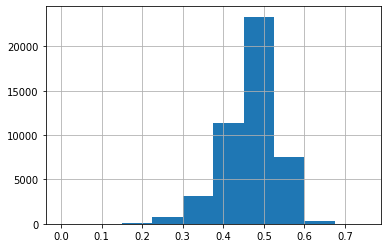

In [ ]:
# Plot the histgraom of stopwords
df.pct_stopwords.hist() # distribution of stopwords

In [ ]:
# select reviews with 0 percent stopwords
# use df.loc[condition, 'reviewtext'] with the appropriate condition
df.loc[df.pct_stopwords==.0, 'reviewtext']

2018     Good service csdgh jhggrr hfdsew bczss hgdsssa...
8014     良かったところ： 高級感あふれるホテル内装の装飾が素敵でした。 とにかく何でも高価なので、高...
38546    good value, nice pool & seafood buffet...........
42284    Great stay. !!!!!!!!!!!!Great stay. !!!!!!!!!!...
Name: reviewtext, dtype: object

**Answer this**
There should only be 1 non-English review above. What is its index number?

1. 8014

In [ ]:
# remove the non-english review
# use df = df.loc[df.index != the non-english review index].reset_index()

df = df.loc[df.index!=8014].reset_index() # fill this in

In [ ]:
# compute the polarity and subjectiity using the TextBlob library for every review
# create 2 new columns for these values: 'polarity' and 'subjectivity'

df['polarity'] = df['reviewtext'].apply(lambda x: TextBlob(x).sentiment.polarity) # calculate polarity and subjectivity in one shot
df['subjectivity'] = df['reviewtext'].apply(lambda x: TextBlob(x).sentiment.subjectivity) # calculate polarity and subjectivity in one shot

# this may take a few minutes to run

In [ ]:
# compute the correlation matrix betwee reviewrating, polarity, and subjectivity
df[['reviewrating', 'polarity', 'subjectivity']].corr()

,reviewrating,polarity,subjectivity
reviewrating,1.000000,0.591453,0.237701
polarity,0.591453,1.000000,0.440534
subjectivity,0.237701,0.440534,1.000000


**Answer this**
What does the correlation between review rating and subjectivity tell you about the information contained in the review text vs. the rating? Is review rating an adequate summary statistic about the review text's polarity?

1. **As we can see, review rating and subjectivity have a low correlation (0,2377). It is obvious because a person can be very subjective writting (high subjectivity) and give a bad review rating (low rating) or a person can be totally objective (low subjectivity) and give a good review rating (high rating). We didn´t need to know the correlation values for arriving to this conclusion, this was logical.**

2. **Regarding the second question, review rating and polarity have a 0,59 correlation, an intermediate correlation. In my opinion that is not enough due to two factors: our pre-trained sentiment model is not trained specifically for hotels and the user-level biases in general sentiment (this means that: I would just give 4 starts to a very good hotel while other person will give 4 stars if the hotel is a regular hotel.**

What about the correlation between polarity and subjectivity, what can you conclude about reviewers' emotionality (subjectivity) as a function of polarity? (Review what correlation measures and then apply that logic to these 2 sentiment variables) 

1. **As far as I am concerned, the coefficient of correlation quantify the intensity of the linear relation between two variables. In this case, 0,44 , a low correlation.**

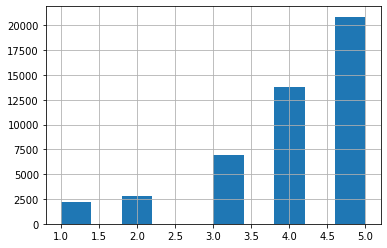

In [ ]:
# plot the histogram of review rating
df.reviewrating.hist()

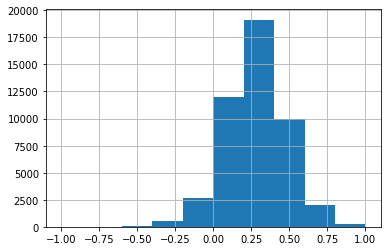

In [ ]:
# plot the histogram of polarity
df.polarity.hist()

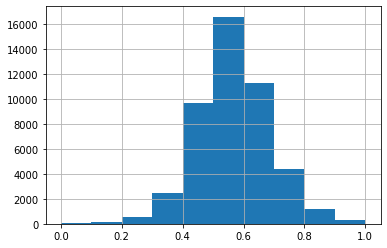

In [ ]:
# plot the histogram of subjectivity
df.subjectivity.hist()

**Answer this**
1. Are most reviews positive or negative?
    1. **As we can see in the first histogram, the most of the reviews are positive because the most of them are placed between (0,1)**
1. Are most reviews subjective or objective? (subjective >.5)
    1. **As we can see in the second histogram the most of the reviews are subjective.**

In [ ]:
# compute the average polarity and review rating by travel_category
# use a groupby statement 
df.groupby('travel_category')['polarity', 'reviewrating'].mean().sort_values(by = 'polarity')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,polarity,reviewrating
travel_category,,
business,0.262430,3.900085
solo,0.279972,4.080357
friends,0.282550,3.988150
family,0.285480,4.054054
couple,0.286445,4.119497


**Answer this**

Are the ranks of categories by review rating the same as the ranks by polarity? If not, posit some potential explanations.

**Answer here**

# Preprocessing for topic analysis (1)

Before we can do topic analysis, we need to pre-process the texts.

1. Lemmatization
1. Phrase detection

These steps may take some time.


## Lemmatization

**Answer this** 

1. What is the purpose of lemmatization? 
    1. **Make more efficient the Topic analysis, actually, it is the key of the topic analysis. It transform all the words to its basic form. .**
1. How does lemmatization help simplify the topic modeling problem? 
    1. **It is very useful with verbs, singular/plurals, perfixes and suffixes... Also removes from the text the stopwords. Summarizing, it previously cleans the text for its proper analysis **
1. Give at least 3 examples of how some words may be lemmatized.
    1. had, has... --> all becomes have
    1. helicopters --> helicopter
    1. Remove pronouns, conjuctions, articles --> Ex: eliminates "I"

In [20]:
# Create an nlp subfolder if it doesn't yet exist
# call this subfolder nlppath
nlppath = fpath + 'nlppath/'
try:
    os.listdir(nlppath)
except:
    os.mkdir(nlppath)

In [21]:
# remove any return or new line characters from the review texts
# replace reviewtext column with the cleaned up review texts
df['reviewtext'] = df.reviewtext.str.replace('\r', '').str.replace('\n', '')

In [22]:
# create a list of review texts from column of review texts
texts = list(df.reviewtext)

# write the raw texts to disk where 1 row = 1 review
with open(nlppath + 'rawtexts.txt', 'w', encoding = 'utf-8') as f:
    f.write('\n'.join(texts))

In [23]:
# import stopwords again
sw = stopwords.words('english')


In [24]:
# use the spacy library, create the variable nlp which is the english language model
# i.e. nlp = spacy.load(...)
nlp = spacy.load('en_core_web_sm')

In [ ]:
# use the write_parsed_sentence_corpus function to lemmatize the reviews
# do not stop this cell, if you do, you must reload the nlp function in previous cell before executing again

readfile = nlppath + 'rawtexts.txt' # use the location of the raw review texts
writefile = nlppath + 'review_sentences.txt' # specify a location for the lemmatized review sentences

t0 = time.time() # time your code
write_parsed_sentence_corpus(readfile, writefile, nlp, batch_size = 1000, n_threads = 1, sw=sw, exclusions = ['-PRON-'], encode = 'utf-8')
td = (time.time()-t0)/60

Success


In [ ]:
# print out how long it took to run
print('Took {:.2f} minutes'.format(td)) 

Took 6.82 minutes


**Answer these**
1. Explain the logic behind how phrase detection (aka phrase modeling) works.
    1. **If words appear frequently in a sequence next to each other means that they could be treated as a unique word. For instance, Backstreet Boys, if you don´t analyze both words together you will never figure out that the topic of the text that you are analyzing is the music band called Backstreet Boys** 
1. If phrase modeling is run twice, what is the maximum length of a detected phrase?
    1. **4**

In [25]:
# run phrase detection
t0 = time.time() # time your code
# ngrams = phrase_detection(....)
ngrams = phrase_detection(nlppath + 'review_sentences.txt', nlppath)  # runs 2 iterations by default
td = (time.time()-t0)/60 #calculate time difference

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [26]:
print('Took {:.2f} minutes'.format(td))

Took 0.83 minutes


In [27]:
# list the nlppath directory
os.listdir(nlppath)

['rawtexts.txt',
 'review_sentences.txt',
 'phrase_model_1.phrasemodel',
 'sent_gram_1.txt',
 'phrase_model_2.phrasemodel',
 'sent_gram_2.txt',
 'parsed_reviews.txt',
 'TripAdvisor_parsed.csv']

In [28]:
# use line_doc to preview a few sentences from sent_gram_2
# construct line generator here, call it "lines":
lines = line_doc(nlppath + 'sent_gram_2.txt')

In [29]:
# preview sentences here, run this cell a few times, make sure you see some phrases
# phrases are denoted by "_" combining 2 words
next(lines) 

'excellent property\n'

In [30]:
# use phrase_prediction function to produce a file that is lemmatized and phrased and 1 line = 1 **review**
# each review will be lemmatized and phrase-detected
nlp = spacy.load('en_core_web_sm')

t0 = time.time()
phrase_prediction(nlppath + 'rawtexts.txt', nlppath + 'parsed_reviews.txt',nlp, ngrams, sw = sw, exclusions = ['-PRON-'], batch_size = 500, n_threads = 2, encode = 'utf-8')
td = (time.time()-t0)/60 #calculate time difference

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [31]:
print('Took {:.2f} minutes'.format(td))

Took 7.85 minutes


In [32]:
# let's take a look at what we did
# construct line generator here, call it "lines", to preview the output of the 
# phrase prediction step

lines = line_doc(nlppath + "parsed_reviews.txt") # fill this in here

In [33]:
# look at a few reviews
next(lines)

'excellent property room nicely generous_size service top_notch art throughout property stunning everyone sight helpful_friendly stay several high_end property vegas nice experience price fair always depend time visit highly_recommend\n'

In [34]:
# read in reviews file as list of reviews
with open(nlppath + 'parsed_reviews.txt', 'r', encoding = 'utf-8') as f:
    reviews = f.readlines()

In [35]:
# make sure list of parsed reviews is the same length as the dataframe
len(reviews), len(df)

(46644, 46644)

In [36]:
# set column, parsed, to equal list of parsed reviews
df['parsed'] = reviews

In [37]:
# Save the dataframe
if 1==1:
    df.to_csv(nlppath + 'TripAdvisor_parsed.csv', encoding = 'utf-8')
else:
    df = pd.read_csv(nlppath + 'TripAdvisor_parsed.csv', index_col = 0, encoding = 'utf-8')

# TFIDF Model (3 points)

**Answer these**
1. What does TF-IDF stand for? 
    1. **Term frequency x Inverse document but infrequently across documents**
1. What are the 2 fundamental ways of counting word frequencies that is embedded into the logic of TF-IDF? In your own words, what is the logical relationship between each type of word frequency and the word's importance in representing a document.
    1. **First one**
        1. **Explain logic**
    1. **Second one**
        1. **Explain logic**

## Construct dictionary and corpus

In [38]:
# list of documents as list of words where 1 document = all reviews for a business
reviews = list(df.parsed.str.split()) # construct list of list of words (outer list is per review)

# compute dictionary
dictionary = corpora.Dictionary(reviews)

# look at number of words in vocabulary
print(len(dictionary))

45545


**Answer these**

1. Why might you want to filter out words that appear in too few documents?
    1. **If they appear less time than the others is because they are less important than the others and skiping them will help us to save time. The most of the no-frequent Words are irrelevant for the text. Other reason is to avoid misspellings**
1. Why might you want to filter out words that appear in too many documents?
    1. **Because they are so generic words that doesn´t give new information to the text. Example: Hotel or Food**


In [39]:
# filter out too frequent or too infrequent words
dictionary.filter_extremes(no_below=10, no_above=.10)
# no_below is the lower qualifying limit of documents in which a word appears
# no_above is the upper qualifying proportional limit in which a word appears
print(len(dictionary))


11403


In [40]:
# construct a corpus which is like list of bag of words
# where each bag of words is a dictionary of word ID's mapped to word count in document
corpus = [dictionary.doc2bow(r) for r in reviews]

## Create the TF-IDF model, look at keywords for a few reviews

In [41]:
tfidf = tfidfmodel.TfidfModel(corpus, dictionary = dictionary) # compute the tfidf model

In [42]:
def tfidf_keywords(txt, tfidf, dictionary, topn = 5):
    """
    Takes in a parsed string, txt
    a tfidf mode, tfidf
    a gensim dictionary, dictionary,
    and parameter topn that defines the number of top keywords to return
    outputs topk, a list of tuples (keyword, keyword tfidf score)
    """
    topk = sorted([(dictionary[t],f) for t,f in tfidf[dictionary.doc2bow(txt)]], key=lambda x: -x[-1])[:topn]
    return topk

In [43]:
# create column of top5 words
df['top5_tfidf'] = df.parsed.str.split().apply(lambda x: tfidf_keywords(x, tfidf, dictionary, topn = 5))

In [44]:
# randomly sample a review (run a few times)
r = df.sample(1) # sample a single row, r
txt = r.reviewtext.iloc[0] # extract review text
rating = r.reviewrating.iloc[0]
hotel = r.v_name.iloc[0]
keywords = r.top5_tfidf.iloc[0] # extract TFIDF keywords 
print('{} star review'.format(rating), hotel)
print(txt)
print(keywords)

5 star review Venetian Resort Hotel Casino
The Venetian exceeded our expectations in every way. I have stayed in many Las Vegas hotels on the strip and this is now my favorite. The service is impeccable. The rooms are spacious and well appointed. The dining options are outstanding. There are plenty of first class shops and the casino is wonderful with plenty of gaming options. My wife and I visited the week of March Madness so the city was quite busy. The Venetian handled the influx with aplomb. We will definitely be back.
[('week_march', 0.3320674821830996), ('spacious_well_appoint', 0.30132801687412797), ('madness', 0.28953427531596415), ('service_impeccable', 0.282258828067937), ('venetian', 0.2789421716515537)]


**Answer this**

Try to sample a few reviews and their respective keywords, did they make sense? Explain.

1. **There is still meaningless words like total with a tfidf=0,3 of score**
1. **I found that the system joined the word "location_middle_strip" in the sentence: The location was in the middle of all the strip action. With a  tfidf=0,4. That means that Phrase detection worked. That is also a very important finding**
1. **In the restaurant of one of the hotels the most important words were: "coke" and "sport_book". If you just read this analysis you think that they serve really good coke and they  have a really nice sport book, however if you read the review you realize that they are saying taht they don´t like the new sports book and that they don´t sreve Coke Cola.**
1. **In other one the highest was (whole_family, 0,43). The first logical conclusion that you extract from that analysis is that it is a family-friendly hotel. However, when reading the review you realize that they mean just the opposite.**
1. **The highest score I found agter running several times the above code was: (fill_smoke, 0,5617). This one made sense because the casino had a filled smoke room.**

# Run LDA Model, explore topics (4 points)

**Answer this**

In your own words, 1) describe LDA model 2) what advantages does it have over TF-IDF?

1. **The LDA model follows this scheme: document, topic and words. It divides a Document in its topics and one topic in its words.**
2. **While TF-IDF just on the performance of each word, LDA groups the words that appear together frequently to make topics. This fact, allows use to do things like know which is the topic more repeated in the 5-star reviews (the strenghts of our business) and the topic more repeated in the 1-star reviews (the weaknesses of our business). Thanks to grouping the words and labeling them we can synthesize better the information.** **Also, when doing TF-IDF we new that the most relevant word in a review is balcony, but we didn´t know whether the customer was happy with the balcony. However, LDA will group balcony with the most frequently words that follow balcony in the reviews (maybe adjectives about the balcony) and in this way we can discover if the customer was satisfied with the balcony or not** 

In [45]:
from gensim.models.ldamulticore import LdaMulticore # import lda function
run = True
if run:
    t0 = time.time()
    perplexity = list()
    # define a training and testing set
    corpus_train, corpus_test = train_test_split(corpus, test_size = .05)
    for numtopics in range(20, 201, 20): # loop through 20,40,...200 topics
        lda = LdaMulticore(corpus_train, id2word=dictionary, num_topics=numtopics)
        lda.save(nlppath+'lda{}.lda'.format(numtopics)) # save the model so we can load it up again later w/o running the model
        p = lda.log_perplexity(corpus_test) # compute the perplexity on testing set
        # save numtopics,p to the perplexity list 
        perplexity.append([numtopics, p])
        # print out number of topics
        print(numtopics)
    perplexity = pd.DataFrame(perplexity, columns = ['ntopics', 'perplexity'])
    td = time.time()-t0
    print('Took {:.2f} minutes'.format(td/60))

20
40
60
80


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


100
120
140
160
180
200
Took 17.81 minutes


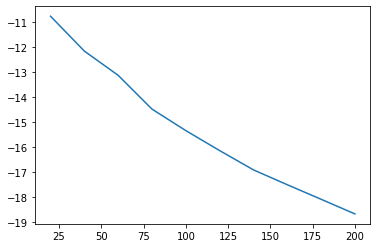

In [46]:
if run:
    plt.plot(perplexity.ntopics, perplexity.perplexity)

**Answer Question**

How many topics appear to minimize perplexity? **200 topics**

In [47]:
# Load lda best model
ntopics = 200
lda = LdaMulticore.load(nlppath + 'lda{}.lda'.format(ntopics))
lda.minimum_probability = 0.

In [48]:
# view all topics
lda.show_topics(ntopics)

[(0,
  '0.030*"$_5" + 0.030*"initially" + 0.025*"suck" + 0.025*"lol" + 0.021*"mid" + 0.016*"pass" + 0.013*"think" + 0.012*"mix" + 0.011*"chip" + 0.011*"holiday_inn"'),
 (1,
  '0.044*"towel" + 0.023*"shower" + 0.018*"floor" + 0.018*"door" + 0.018*"light" + 0.012*"think" + 0.011*"husband" + 0.011*"let" + 0.010*"first" + 0.009*"turn"'),
 (2,
  '0.032*"work" + 0.032*"fix" + 0.030*"security" + 0.020*"issue" + 0.019*"leave" + 0.017*"call" + 0.016*"never" + 0.015*"3" + 0.014*"phone" + 0.014*"contact"'),
 (3,
  '0.056*"flamingo" + 0.026*"popular" + 0.024*"beverage" + 0.024*"property" + 0.023*"locate" + 0.021*"reasonable" + 0.016*"comfortable" + 0.014*"accessible" + 0.014*"awesome" + 0.013*"fun"'),
 (4,
  '0.089*"child" + 0.040*"us" + 0.019*"perform" + 0.018*"satisfy" + 0.013*"craziness" + 0.012*"iphone" + 0.012*"identification" + 0.011*"hassle" + 0.011*"send_someone" + 0.010*"change"'),
 (5,
  '0.023*"charge" + 0.018*"charge_resort_fee" + 0.017*"half" + 0.015*"free_valet_parking" + 0.015*"auto

**Answer this**

Pick 3 topics that you can label. Explain your label choice. 

1. **Topic 11: I will call it "Facilities" because some of the more relevant words are: "swimming pool, theatre, free-wifi...**
2. **Topic 187: I will call it: "views" because some of the more relevant words are: "cosmopolitan, balcomny, terrace, amazing, walkway.**
3. **Topic 153: I will call it "Excelent Drinks-bar" because the most relevant words are: cocktail, tasty, amazing, wine, bar and white (making reference to white wine i think).**


**Explore topics**

In [49]:
# predict back the topic weights on each review
df['topic_probs'] = df.parsed.str.split().apply(lambda x: dict(lda[dictionary.doc2bow(x)]))


In [50]:
# create top_k  columns for k = 0,...,ntopics
# where top_k is the probability of each review representing topic k
for t in range(ntopics):
    df['top_{}'.format(t)] = df.topic_probs.apply(lambda x: x.get(t))


In [51]:
# create a variable that contains the list of top_k column names
topiccols = ['top_{}'.format(t) for t in range(ntopics)]

### Topics by travel category

In [52]:
# for each travel category, compute the average of all the topiccols 
# use .T at the end to transpose (i.e. rotate 90 deg) the dataframe
topicmeans = df.groupby('travel_category')[topiccols].mean().T

In [53]:
# preview the topicmeans dataframe
topicmeans.head()

travel_category,business,couple,family,friends,solo
top_0,0.003656,0.003819,0.003278,0.004147,0.004482
top_1,0.006578,0.007156,0.006584,0.005744,0.005924
top_2,0.011526,0.008771,0.010060,0.010546,0.009527
top_3,0.004213,0.004803,0.005770,0.005741,0.005927
top_4,0.002499,0.002907,0.005103,0.002805,0.003123


In [54]:
# use sort_values on topicmeans to find the common topic among solo travelers
# use ascending = False option in sort_values to sort from largest to smallest
topicmeans.sort_values(by = 'solo', ascending = False)

travel_category,business,couple,family,friends,solo
top_50,0.013633,0.017263,0.019090,0.023789,0.017072
top_47,0.010666,0.010141,0.013247,0.012138,0.016533
top_41,0.008719,0.010849,0.017405,0.012818,0.015031
top_68,0.008655,0.009928,0.009625,0.014494,0.014124
top_99,0.016228,0.014791,0.015354,0.015110,0.013825
...,...,...,...,...,...
top_52,0.003339,0.003228,0.004209,0.003743,0.002178
top_172,0.002523,0.002396,0.002711,0.002352,0.002161
top_70,0.002376,0.002190,0.002005,0.002376,0.002109
top_69,0.002434,0.002059,0.002034,0.002147,0.002089


**Answer this**

What is the topic ID for solo travelers' most likely review topic? **50**

In [57]:
# take a look at the top solo traveler topic
top_solo = 50 # use the most common solo traveler topic ID here
pd.DataFrame(lda.show_topic(top_solo))

,0,1
0,fun,0.099852
1,enjoyable,0.047216
2,staff_friendly_helpful,0.028497
3,visit,0.024834
4,trip,0.017986
5,awesome,0.017403
6,atmosphere,0.017298
7,dining_option,0.016627
8,easy,0.016450
9,relaxing,0.016076


In [58]:
# look at the most common topic for business travelers
topicmeans.sort_values(by = 'business', ascending = False)

travel_category,business,couple,family,friends,solo
top_99,0.016228,0.014791,0.015354,0.015110,0.013825
top_192,0.015659,0.005415,0.005504,0.005087,0.005828
top_31,0.014033,0.010526,0.011150,0.011298,0.010550
top_50,0.013633,0.017263,0.019090,0.023789,0.017072
top_91,0.012730,0.013654,0.012248,0.012692,0.013526
...,...,...,...,...,...
top_141,0.002367,0.002632,0.002663,0.002794,0.002556
top_156,0.002307,0.002626,0.002941,0.002705,0.002859
top_165,0.002288,0.002048,0.001706,0.002038,0.002025
top_150,0.002277,0.002579,0.005085,0.002707,0.003035


In [59]:
# preview the most common topic for business travelers
top_solo = 99
pd.DataFrame(lda.show_topic(top_solo))

,0,1
0,tell,0.051346
1,call,0.037260
2,ask,0.032353
3,manager,0.021340
4,front_desk,0.019993
5,never,0.017630
6,book,0.015376
7,give,0.014759
8,come,0.014608
9,back,0.011784


In [61]:
# look at the most common topic for couples
topicmeans.sort_values(by = 'couple', ascending = False)

travel_category,business,couple,family,friends,solo
top_50,0.013633,0.017263,0.019090,0.023789,0.017072
top_99,0.016228,0.014791,0.015354,0.015110,0.013825
top_91,0.012730,0.013654,0.012248,0.012692,0.013526
top_190,0.010229,0.012737,0.012667,0.012212,0.010642
top_41,0.008719,0.010849,0.017405,0.012818,0.015031
...,...,...,...,...,...
top_172,0.002523,0.002396,0.002711,0.002352,0.002161
top_70,0.002376,0.002190,0.002005,0.002376,0.002109
top_10,0.002065,0.002096,0.002121,0.002446,0.002477
top_69,0.002434,0.002059,0.002034,0.002147,0.002089


In [62]:
# preview the most common topic for business travelers
top_solo = 50
pd.DataFrame(lda.show_topic(top_solo))

,0,1
0,fun,0.099852
1,enjoyable,0.047216
2,staff_friendly_helpful,0.028497
3,visit,0.024834
4,trip,0.017986
5,awesome,0.017403
6,atmosphere,0.017298
7,dining_option,0.016627
8,easy,0.016450
9,relaxing,0.016076


### Topics by rating for 1 hotel

In [63]:
# print out unique hotels
df.v_name.unique()

array(['Encore At Wynn Las Vegas', 'New York - New York Hotel and Casino',
       "Bally's Las Vegas", 'Venetian Resort Hotel Casino',
       'Rio All-Suite Hotel & Casino', 'Wynn Las Vegas',
       'MGM Grand Hotel and Casino',
       'Tropicana Las Vegas - A DoubleTree by Hilton Hotel',
       'Excalibur Hotel & Casino', 'Monte Carlo Resort & Casino',
       'The LINQ Hotel & Casino', 'Hard Rock Hotel and Casino',
       'Paris Las Vegas', 'The Mirage Hotel & Casino',
       'Trump International Hotel Las Vegas', 'Plaza Hotel & Casino',
       'Caesars Palace', 'Luxor Las Vegas', 'Signature at MGM',
       'Planet Hollywood Resort & Casino', 'Vdara Hotel & Spa',
       'Golden Nugget Hotel', 'Treasure Island - TI Hotel & Casino',
       'Stratosphere Hotel, Casino and Tower',
       'Mandalay Bay Resort & Casino',
       'The Cosmopolitan of Las Vegas, Autograph Collection',
       'SLS Las Vegas Hotel & Casino', 'Bellagio Las Vegas',
       'Circus Circus Hotel & Casino Las Vegas',


In [89]:
# pick out a hotel to analyze in detail
hotel = 'Wynn Las Vegas'
df_h = df.loc[df.v_name==hotel].reset_index(drop = True)

In [90]:
# compute the average topic probability for each rating level
topicmeans = df_h.groupby('reviewrating')[topiccols].mean().T

In [91]:
# look at top topics for 1 star ratings
topicmeans.sort_values(by = 1, ascending = False)

reviewrating,1,2,3,4,5
top_99,0.117428,0.046521,0.040151,0.011111,0.003009
top_179,0.052831,0.006739,0.024299,0.012474,0.001743
top_56,0.037073,0.030749,0.043103,0.055080,0.067656
top_114,0.033532,0.003310,0.002826,0.003347,0.003443
top_2,0.032002,0.021600,0.006317,0.007246,0.005170
...,...,...,...,...,...
top_167,0.000141,0.002540,0.001720,0.005331,0.002930
top_98,0.000141,0.000149,0.003525,0.002906,0.005218
top_176,0.000141,0.004538,0.000512,0.009897,0.004593
top_148,0.000141,0.003530,0.001531,0.005308,0.002369


In [92]:
# look at the highest rated topic for 1 star ratings
lda.show_topic(99) 

[('tell', 0.051346123),
 ('call', 0.037260216),
 ('ask', 0.032353334),
 ('manager', 0.021340223),
 ('front_desk', 0.019992596),
 ('never', 0.017629527),
 ('book', 0.015375988),
 ('give', 0.0147587545),
 ('come', 0.014608159),
 ('back', 0.011784327)]

In [93]:
# look at top topics for 5 star ratings
topicmeans.sort_values(by = 5, ascending = False)


reviewrating,1,2,3,4,5
top_56,0.037073,0.030749,0.043103,0.055080,0.067656
top_190,0.002611,0.004089,0.013188,0.009702,0.026505
top_50,0.001185,0.003550,0.005320,0.010320,0.017689
top_91,0.001390,0.005511,0.008675,0.010045,0.017562
top_121,0.006092,0.006446,0.014394,0.015437,0.016721
...,...,...,...,...,...
top_10,0.001731,0.001486,0.001922,0.002184,0.001342
top_132,0.004028,0.007165,0.001812,0.001877,0.001296
top_27,0.003178,0.000930,0.000509,0.002437,0.001287
top_52,0.002903,0.000149,0.000530,0.001190,0.001284


In [94]:
# look at the highest rated topic for 5 star ratings
# that are not in the top 5 for 1 star ratings
lda.show_topic(190) 


[('wonderful', 0.049491934),
 ('spotless', 0.027169256),
 ('vacation', 0.027060749),
 ('amazing', 0.02538871),
 ('thank', 0.02187175),
 ('visit', 0.016416851),
 ('top_notch', 0.013307931),
 ('feel_safe', 0.012535237),
 ('take_care', 0.012424184),
 ('trip', 0.012193279)]

**Answer Question**

Any intuition behind the distinctive 5 star topic and the top 1 star topic? Explain.

1. **Yes, they are two reviews for the same hotel and the people who wrote the bad one had problems with the staff of the hotel while the people who wrote the good one felt thankful with the hotel and and i guess that he/she felt that the hotel took care of him/her.**

# Create wordcloud from LDA (+2 Bonus)



## Example for creating 1 wordcloud

In [70]:
# to get the topic weights for topic k:
k = 0
# topn = number of top words to use
topicwts = dict(lda.show_topic(k, topn = 100))

In [71]:
from wordcloud import WordCloud
wc = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts) # specify w/h for HD figure

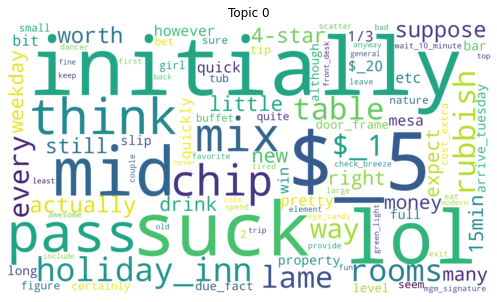

In [72]:
# plot wc
plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation='bilinear')
plt.title('Topic {}'.format(k))
plt.axis('off')
plt.show()

## Challenge problem (for the bonus): 
Use only the data from your chosen hotel, i.e. df_h.

For positive and negative reviews, where positive is 4-5 stars and negative is 1-3 stars, create a wordcloud for any of the top 5 topics for that category of ratings that are not in the top 5 of the other category. For instance, if topic 88 is one of the top 5 topics for negative reviews and **not** one of the top 5 topics for positive reviews, then create a wordcloud for it. Make sure that the title of the wordcloud image reflects the review type (positive/negative) and the topic number: e.g., 'Positive review topic: 88'.

*Use what you have learned throughout the semester and the internet to figure out how to do this without any hard-coded results, especially with respect to selecting the topics to visualize. For example: use code to write a generic solution such that you do not have to manually select the topics used for word cloud. If you had to re-run the code where top 5 topics is now top 3 topics, you should only have to change the 5 to 3 once in the code.



In [ ]:
# solution below, feel free to add multiple additional cells

In [76]:
hotel1 = 'Monte Carlo Resort & Casino'
df_h = df.loc[df.v_name==hotel1].reset_index(drop = True)

In [77]:
topicmeans1 = df_h.groupby('reviewrating')[topiccols].mean().T

In [78]:
topicmeans.sort_values(by = 1, ascending = False)

reviewrating,1,2,3,4,5
top_99,0.113077,0.070097,0.028084,0.013001,0.005552
top_2,0.042332,0.030379,0.015613,0.008065,0.003626
top_179,0.035204,0.018367,0.009944,0.006093,0.003980
top_136,0.026971,0.028635,0.024010,0.047968,0.056251
top_151,0.024644,0.021406,0.009426,0.003743,0.002756
...,...,...,...,...,...
top_57,0.000268,0.000752,0.001399,0.002448,0.002295
top_39,0.000268,0.001086,0.002135,0.002810,0.004701
top_96,0.000243,0.003448,0.001897,0.003704,0.002980
top_83,0.000217,0.001508,0.002738,0.001945,0.003854


In [80]:
topicmeans.sort_values(by = 2, ascending = False)

reviewrating,1,2,3,4,5
top_99,0.113077,0.070097,0.028084,0.013001,0.005552
top_2,0.042332,0.030379,0.015613,0.008065,0.003626
top_136,0.026971,0.028635,0.024010,0.047968,0.056251
top_180,0.017835,0.022207,0.017294,0.011064,0.014680
top_151,0.024644,0.021406,0.009426,0.003743,0.002756
...,...,...,...,...,...
top_178,0.000127,0.000569,0.004489,0.002673,0.001909
top_65,0.002149,0.000473,0.002671,0.001492,0.004104
top_152,0.002386,0.000291,0.001730,0.006085,0.010495
top_183,0.002457,0.000187,0.002454,0.005316,0.003329


In [81]:
topicmeans.sort_values(by = 3, ascending = False)

reviewrating,1,2,3,4,5
top_99,0.113077,0.070097,0.028084,0.013001,0.005552
top_136,0.026971,0.028635,0.024010,0.047968,0.056251
top_1,0.022210,0.019693,0.022394,0.008382,0.003788
top_59,0.014509,0.013884,0.017511,0.003947,0.001526
top_180,0.017835,0.022207,0.017294,0.011064,0.014680
...,...,...,...,...,...
top_26,0.002978,0.001228,0.001222,0.002536,0.002458
top_170,0.001447,0.003445,0.000935,0.001523,0.002441
top_3,0.002752,0.002224,0.000859,0.003008,0.004126
top_172,0.001883,0.001029,0.000626,0.001490,0.001997


In [82]:
topicmeans.sort_values(by = 4, ascending = False)

reviewrating,1,2,3,4,5
top_136,0.026971,0.028635,0.024010,0.047968,0.056251
top_99,0.113077,0.070097,0.028084,0.013001,0.005552
top_188,0.000620,0.001754,0.008083,0.012928,0.011755
top_50,0.001307,0.001596,0.004554,0.012092,0.021667
top_74,0.006867,0.010768,0.008721,0.012002,0.006279
...,...,...,...,...,...
top_65,0.002149,0.000473,0.002671,0.001492,0.004104
top_172,0.001883,0.001029,0.000626,0.001490,0.001997
top_191,0.000290,0.000964,0.003133,0.001100,0.002070
top_132,0.003167,0.004013,0.003042,0.001042,0.001005


In [79]:
topicmeans.sort_values(by = 5, ascending = False)

reviewrating,1,2,3,4,5
top_136,0.026971,0.028635,0.024010,0.047968,0.056251
top_190,0.003570,0.000953,0.003065,0.008370,0.030433
top_50,0.001307,0.001596,0.004554,0.012092,0.021667
top_91,0.000344,0.000977,0.006284,0.009219,0.015141
top_180,0.017835,0.022207,0.017294,0.011064,0.014680
...,...,...,...,...,...
top_59,0.014509,0.013884,0.017511,0.003947,0.001526
top_10,0.001560,0.001971,0.001350,0.002908,0.001457
top_20,0.002476,0.006001,0.001715,0.002841,0.001411
top_97,0.001081,0.003225,0.001710,0.001938,0.001198


Negative 1-Star Review Topic 2


Negative 2-Star Review Topic 151


Negative 3-Star Review Topic 1


Positive 4-star Review Topic 188


Positive 5-star Review Topic 190

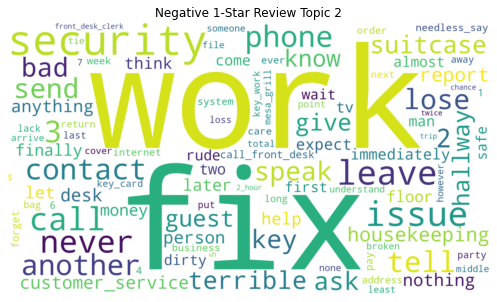

In [84]:
k = 2
topicwts = dict(lda.show_topic(k, topn = 100))
from wordcloud import WordCloud
wc1 = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts)

plt.figure(figsize = (10,5))
plt.imshow(wc1, interpolation='bilinear')
plt.title('Negative 1-Star Review Topic {}'.format(k))
plt.axis('off')
plt.show()

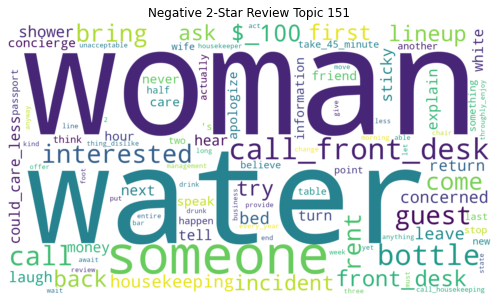

In [85]:
k = 151
topicwts = dict(lda.show_topic(k, topn = 100))
from wordcloud import WordCloud
wc1 = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts)

plt.figure(figsize = (10,5))
plt.imshow(wc1, interpolation='bilinear')
plt.title('Negative 2-Star Review Topic {}'.format(k))
plt.axis('off')
plt.show()

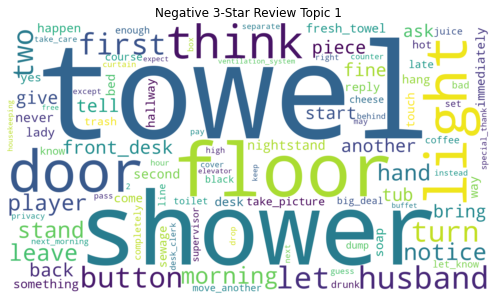

In [86]:
k = 1
topicwts = dict(lda.show_topic(k, topn = 100))
from wordcloud import WordCloud
wc1 = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts)

plt.figure(figsize = (10,5))
plt.imshow(wc1, interpolation='bilinear')
plt.title('Negative 3-Star Review Topic {}'.format(k))
plt.axis('off')
plt.show()

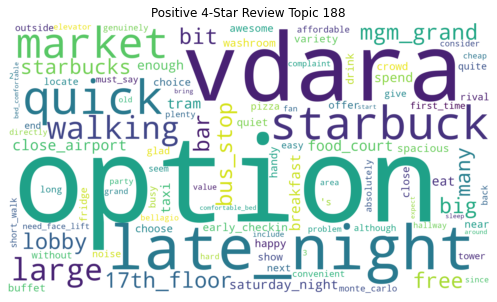

In [87]:
k = 188
topicwts = dict(lda.show_topic(k, topn = 100))
from wordcloud import WordCloud
wc1 = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts)

plt.figure(figsize = (10,5))
plt.imshow(wc1, interpolation='bilinear')
plt.title('Positive 4-Star Review Topic {}'.format(k))
plt.axis('off')
plt.show()

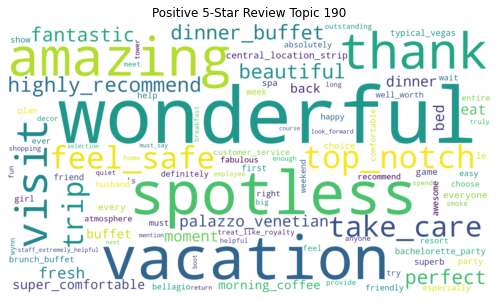

In [88]:
k = 190
topicwts = dict(lda.show_topic(k, topn = 100))
from wordcloud import WordCloud
wc1 = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts)

plt.figure(figsize = (10,5))
plt.imshow(wc1, interpolation='bilinear')
plt.title('Positive 5-Star Review Topic {}'.format(k))
plt.axis('off')
plt.show()